In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lightgbm as lgb
import catboost as cb
from keras.wrappers.scikit_learn import KerasRegressor
from keras import Sequential
from keras.layers import Dense

from tsfresh.examples import load_robot_execution_failures
from tsfresh import extract_features, select_features
import optuna

from common import EP
from models import *

import types
import os

import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/ubuntu/.conda/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [80]:
pd.set_option('display.max_colwidth', -1)

In [2]:
%%HTML
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 65%; }
   div#maintoolbar-container { width: 99%; }
</style>

In [3]:
def m_lineplot(dflist, plot_features=None, n_col=3):

    
    n_chart = len(dflist)
    n_row = int(n_chart/n_col) if n_chart % n_col == 0 else n_row+1
        
    fig = plt.figure(figsize=(5*n_col, 3*n_row))
    for i, df in enumerate(dflist):
        ax = fig.add_subplot(n_row, n_col, i+1)
        if type(plot_features) == type(None):
            plot_features = df.columns.tolist()
        for feat in plot_features:
            sns.lineplot(x=df.index, y=df[feat], ax=ax)
    return 

In [4]:
df_train = pd.read_pickle('../feats/df_train.pkl')
df_test = pd.read_pickle('../feats/df_test.pkl')

In [5]:
df_train['label'] = df_train['y'].apply(lambda x:  int(x) if x<15 else 15)
group = df_train['season'].values
group[np.where(group==17)[0]] = 1
df_train['group'] = group
df_train = df_train.drop(columns=['season'])

In [6]:
test_X = df_train.drop(columns=['y','index','group','label']).copy()
test_X.index = df_train['index']
test_y = df_train['y'].copy()
test_y.index = df_train['index']
tsfresh_columns = select_features(test_X, test_y).columns.tolist()

In [7]:
len(tsfresh_columns)

1071

In [8]:
original_columns = df_train.columns.drop(['index','y','label','group']).tolist()

In [9]:
# def create_path(base_dir, param):
#     if base_dir == None:
#         return None
#     fold_path = base_dir + '/' + ','.join("{!s}={!r}".format(key,val) for (key,val) in param.items())
#     if not os.path.exists(fold_path):
#         os.makedirs(fold_path)
#     return fold_path

# class KerasMLPRegressor(object):
    
#     def __init__(self, batch, input_dim, hidden_layer_sizes, activation, dropout, solver, metric, lr, sgd_momentum, sgd_decay, base_save_dir, alias):
        
#         self.batch = batch
#         self.input_dim = input_dim
#         self.hidden_layer_sizes = hidden_layer_sizes
#         self.activation = activation
#         self.solver = solver
#         self.metric = metric
#         self.dropout = dropout
#         self.lr = lr
#         self.sgd_momentum = sgd_momentum
#         self.sgd_decay = sgd_decay
        
#         self.regressor = self.build_graph(input_dim, hidden_layer_sizes, activation, dropout)
#         self.compile_graph(self.regressor, solver, metric, lr, sgd_momentum, sgd_decay)
        
#         self.alias = alias
#         self.base_save_dir = base_save_dir
#         if (self.alias==None) & (self.base_save_dir==None):
#             self.chkpt = None
#         else:
#             self.chkpt = os.path.join(base_save_dir,'{}.hdf5'.format(alias))

#         return
    
#     def build_graph(self, input_dim, hidden_layer_sizes, activation, dropout):
    
#         print(input_dim,hidden_layer_sizes,activation,dropout)
#         i = Input(shape = (input_dim,))
#         x = Dense(hidden_layer_sizes[0], activation=activation)(i)
#         x = BatchNormalization()(x)
#         x = Dropout(dropout)(x)
#         for units in hidden_layer_sizes[1:-1]:
#             x = Dense(units, activation=activation)(x)
#             x = BatchNormalization()(x)
#             x = Dropout(dropout)(x)
#         x = Dense(units, activation=activation)(x)
#         x = BatchNormalization()(x)
#         y = Dense(1)(x)
#         regressor = Model(inputs = [i], outputs = [y])
#         return regressor
    
#     def compile_graph(self, model, solver, metric, lr, momentum, decay):
#         if solver=='adam':
#             optimizer = optimizers.adam(lr=lr)
#         elif solver=='sgd':
#             optimizer = optimizers.SGD(lr=lr, decay=decay, momentum=momentum, nesterov=True)
#         model.compile(optimizer=optimizer, loss=metric)
#         return
    
#     def fit(self, X_train, y_train, eval_set, versbose=1, epochs=200, early_stopping_rounds=20):
        
# #         reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=early_stopping_rounds//4, min_lr=self.lr*1e-2)
#         es_cb = EarlyStopping(monitor='val_loss', patience=early_stopping_rounds, verbose=1, mode='auto')
#         cp_cb = ModelCheckpoint(filepath = self.chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# #         his_train = self.regressor.fit_generator( generator =  train_gen, epochs = epochs,  verbose = 1,  validation_data = validation, callbacks = [cp_cb])
#         his_train = self.regressor.fit( X_train, y_train, epochs = epochs,  verbose = 1,  validation_data = eval_set[0], callbacks = [cp_cb,es_cb])
#         df_train_his = pd.DataFrame(his_train.history)
        
# #         df_train_his = pd.DataFrame()
# #         prev_val_loss = 999999
# #         for i in np.arange(epochs):
# #             his_train = self.regressor.fit( X_train, y_train, epochs = 1,  verbose = versbose,  batch_size = self.batch,  validation_data = validation,  callbacks = [])
# #             df_train_his_i = pd.DataFrame(his_train.history)
# #             df_train_his_i['epochs'] = i+1
# #             df_train_his = pd.concat([df_train_his, df_train_his_i], axis=0)
# #             if (df_train_his_i.val_loss.values[0] < prev_val_loss) & (self.chkpt!=None):
# #                 prev_val_loss = df_train_his_i.val_loss.values[0]
# #                 self.regressor.save_weights(self.chkpt)
                
#         df_train_his.to_csv(self.base_save_dir + '/train_his.csv', index=True)
            
#         return df_train_his
    
#     def predict(self, X):
#         return self.regressor.predict(X)[:,0]
    

In [20]:
catboost_columns = ['spkt_welch_density__coeff_3',
 'abs_q25_5',
 'q25_roll_std_100',
 'abs_q75_6',
 'abs_q75_7',
 'spkt_welch_densitycoeff_2',
 'abs_q01_4',
 'iqr_6',
 'q05_roll_std_100',
 'q05_roll_std_1000',
 'median__roll_std',
 'abs_q01_5',
 "number_peaks{'n': 10}",
 'FFT_Mag_75q0',
 "value_count{'value': 1}",
 'q01_roll_std_100',
 'abs_q95_2',
 'abs_q95_6',
 'MA_1000MA_std_mean_7',
 'q05_roll_std_10',
 'q01_roll_std_1000',
 'abs_max_roll_mean_1000',
 'abs_q75_2',
 'abs_q05_6',
 '5000std_quantile25',
 "number_crossing_m{'m': 1}",
 "autocorrelation{'lag': 5}",
 'q75_roll_std_10',
 'q05_2',
 '5000smoothness_quantile05']

In [22]:
common_columns = ['q25_roll_std_100',
 'abs_q25_5',
 'iqr_6',
 'abs_q01_4',
 'abs_q75_7',
 'spkt_welch_density__coeff_3',
 'spkt_welch_densitycoeff_2']

In [57]:
main_columns = ['q25_roll_std_100',
 'abs_q25_5',
 'q05_roll_std_1000',
 'abs_q95_2',
 'abs_q75_6',
 'iqr_6',
 "autocorrelation{'lag': 5}",
 'median__roll_std',
 'abs_q01_4',
 'q05_roll_std_100',
 'abs_q75_7',
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'spkt_welch_density__coeff_3',
 'spkt_welch_densitycoeff_2']

In [51]:
len(common_columns)

7

In [23]:
columns = ["change_quantiles{'ql': 0.4, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'spkt_welch_density__coeff_65',
 'q05_roll_std_10',
 'Hilbert_mean_2',
 'min__roll_std',
 'spkt_welch_density__coeff_4',
 'abs_max_6',
 'spkt_welch_density__coeff_99',
 'abs_q01_7',
 'abs_max_8',
 'kurt_7',
 'partial_autocorrelationlag_5',
 'q05_2',
 'abs_max_roll_mean_100',
 'spkt_welch_density__coeff_50',
 'abs_q01_6',
 'ave10_6',
 "binned_entropy{'max_bins': 10}",
 'min_roll_std_100',
 'spkt_welch_density__coeff_113',
 'med_6',
 'spkt_welch_density__coeff_42',
 '4th_peak_psd',
 '5000min_quantile05',
 'fft_coefficientcoeff_36__attr_"abs"',
 'spkt_welch_density__coeff_41',
 'q01_roll_std_100',
 'max_to_min',
 'spkt_welch_density__coeff_17',
 'abs_min_5',
 'q25_roll_std_100',
 '5000skewness_mean_',
 "change_quantiles{'ql': 0.2, 'qh': 0.4, 'isabs': True, 'f_agg': 'mean'}",
 'peak_to_average_power_ratio__roll_mean',
 'fft_coefficientcoeff_20__attr_"abs"',
 'fft_coefficientcoeff_50__attr_"abs"',
 "change_quantiles{'ql': 0.2, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'}",
 'q01_roll_std_1000',
 'abs_max_5',
 'FFT_Mag_25q0',
 'abs_q95_7',
 '5000skewness_max_',
 '5000std_quantile05',
 'abs_q25_5',
 "number_peaks{'n': 3}",
 'q05_roll_std_1000',
 'abs_q99_7',
 'abs_q95_2',
 'q75_roll_std_10',
 'spkt_welch_density__coeff_84',
 'abs_q75_6',
 'abs_max_3',
 'kurt_3',
 "change_quantiles{'ql': 0.4, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'}",
 'iqr',
 'spkt_welch_density__coeff_64',
 'fft_coefficientcoeff_8__attr_"imag"',
 'spkt_welch_density__coeff_29',
 'iqr_6',
 "autocorrelation{'lag': 5}",
 'spkt_welch_density__coeff_57',
 'spkt_welch_density__coeff_117',
 'q25_1',
 "number_crossing_m{'m': 1}",
 'fft_coefficientcoeff_32__attr_"imag"',
 'fft_coefficientcoeff_21__attr_"abs"',
 'abs_q95_6',
 'Hilbert_mean_1',
 'skew_1',
 'iqr_9',
 'ave10_2',
 'median__roll_std',
 '5000clearance_factor_quantile25',
 'abs_q95_8',
 '5000smoothness_quantile05',
 'med_4',
 'spkt_welch_density__coeff_28',
 'abs_max_roll_mean_1000',
 '5000kurtosis_mean_',
 'iqr_8',
 '5000kurtosis_quantile75',
 'spkt_welch_density__coeff_31',
 'med_5',
 'min__roll_mean',
 'abs_q01_4',
 'fft_coefficientcoeff_24__attr_"imag"',
 'max_to_min_6',
 'abs_q75_2',
 'q05_5',
 'spkt_welch_density__coeff_25',
 'q05_roll_std_100',
 'abs_q75_7',
 'abs_q01_5',
 'FFT_Mag_75q0',
 'mean_change_rate',
 'med_8',
 'q01_roll_std_10',
 'fft_coefficientcoeff_56__attr_"angle"',
 '3th_peak_freq',
 'abs_q05_9',
 'abs_min_3',
 '5000smoothness_std_',
 'fft_coefficientcoeff_24__attr_"real"',
 'abs_q05_7',
 'q99_roll_mean_1000',
 'abs_q99_8',
 '5000rms_quantile25',
 'abs_max_7',
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'q95_roll_mean_1000',
 '5000quantile25peak_to_average_power_ratio_',
 "number_peaks{'n': 10}",
 'abs_q05_6',
 'spkt_welch_density__coeff_3',
 'spkt_welch_density__coeff_38',
 'spkt_welch_density__coeff_115',
 'abs_q25_9',
 'fft_coefficientcoeff_62__attr_"abs"',
 'max_to_min_diff_5',
 'abs_q05_2',
 'fft_coefficientcoeff_80__attr_"imag"',
 "number_peaks{'n': 5}",
 "autocorrelation{'lag': 4}",
 'abs_min_2',
 'FFT_Mag_95q0',
 'spkt_welch_densitycoeff_8',
 'abs_q05_1',
 'min_9',
 "change_quantiles{'ql': 0.0, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'}",
 "number_peaks{'n': 1}",
 'partial_autocorrelationlag_1',
 'q01_roll_mean_1000',
 'abs_max_1',
 'max_to_min_1',
 'abs_min_6',
 'abs_min_7',
 'fft_coefficientcoeff_19__attr_"abs"',
 "value_count{'value': 1}",
 'abs_q25_7',
 "change_quantiles{'ql': 0.6, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'}",
 'MA_1000MA_std_mean_7',
 "value_count{'value': -1}",
 'abs_q25_1',
 'spkt_welch_density__coeff_79',
 'agg_autocorrelationf_agg_"mean"__maxlag_40',
 'max_to_min_5',
 'q95_9',
 'spkt_welch_densitycoeff_2',
 '5000peak_peak_amp_max_',
 'fft_coefficientcoeff_16__attr_"imag"',
 '5000form_factor_quantile75',
 'fft_coefficientcoeff_26__attr_"abs"',
 'spkt_welch_density__coeff_63',
 'med_2',
 '5000std_quantile25',
 'max_9',
 'fft_coefficientcoeff_6__attr_"abs"',
 'spkt_welch_density__coeff_30',
 '5000smoothness_entropy_',
 'abs_max_2',
 'abs_max_4',
 '5000quantile05median_',
 'ave10_7',
 'abs_q25_8',
 'abs_q75_1']

In [11]:
mytrial = list(pd.read_pickle('../trial/kerasmlp.pkl').T.to_dict().values())
df_trial = pd.DataFrame(mytrial)
len(mytrial)

10

In [66]:
len(common_columns)

7

In [70]:
path_param={
    'input_dim':7,
    'hidden_layer_sizes':[64,16],
    'activation':'relu',
    'l1l2regularizer':None,
    'dropout':.3,
}
base_save_dir = create_path('KerasMLPRegressor', path_param)
param={
    'algorithm': {
        'cls': 'KerasMLPRegressor',
        'fit': {
            'versbose':0, 
            'epochs':50, 
            'early_stopping_rounds':20,
        },
        'init': {
            'batch':128, 
            'solver':'adam', 
            'metric':'mean_absolute_error', 
            'lr':.0001, 
            'sgd_momentum':.9, 
            'sgd_decay':0.0001,
            'base_save_dir':base_save_dir, 
            'alias':'kerasmlp',
            **path_param
        }
    },
    'columns': common_columns,
    'feature_importance': {
        'is_output': False,
        'permutation_feature_importance': False,
        'permutation_random_state': 1
    },
    'kfold': {
        'n_splits': 3,
        'random_state': 1985,
        'shuffle': True,
        'type': 'group'#stratified
    },
    'scaler': {
        'cls': 'StandardScaler'
    }
}

In [37]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="3";  
 
# # Do other imports now...
# import keras

In [71]:
# run one try
df_his,  df_feature_importances, df_valid_pred, df_test_pred =  EP.process(df_train, param, df_test = df_test, trial=mytrial)

In [81]:
df_trial = pd.DataFrame(mytrial)
df_trial['kfold-type'] = df_trial['param'].apply(lambda x: x['kfold']['type'])
df_trial['algorithm-init'] = df_trial['param'].apply(lambda x: x['algorithm']['init'])
df_trial[['datetime','nfeatures', 'kfold-type', 'algorithm-init', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,nfeatures,kfold-type,algorithm-init,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
0,2019-05-16 06:55:20.008242,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[1024, 1024, 256, 16],activation='relu',l1l2regularizer=0.01,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [1024, 1024, 256, 16], 'activation': 'relu', 'l1l2regularizer': 0.01, 'dropout': 0.3}",3.029792,0.000091,3.029836,0.000359,0.000044
1,2019-05-16 10:21:58.948983,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[1024, 1024, 256, 16],activation='relu',l1l2regularizer=0.1,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [1024, 1024, 256, 16], 'activation': 'relu', 'l1l2regularizer': 0.1, 'dropout': 0.3}",3.029836,0.000093,3.029870,0.000355,0.000034
2,2019-05-16 11:34:31.195248,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[1024, 1024, 256, 16],activation='relu',l1l2regularizer=1,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [1024, 1024, 256, 16], 'activation': 'relu', 'l1l2regularizer': 1, 'dropout': 0.3}",3.030027,0.000095,3.030167,0.000349,0.000140
3,2019-05-17 00:36:52.261097,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[1024, 1024, 256, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [1024, 1024, 256, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",0.454774,0.000280,0.949574,0.000443,0.494800
4,2019-05-17 02:54:07.726431,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[1024, 256, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [1024, 256, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",0.608211,0.000163,1.134777,0.000121,0.526565
5,2019-05-17 05:12:28.236277,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[512, 512, 256, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [512, 512, 256, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",0.636796,0.000058,1.131104,0.000095,0.494308
6,2019-05-17 06:30:23.637812,165,,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[2048, 2048, 256, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [2048, 2048, 256, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",0.398893,0.001634,0.877269,0.000888,0.478376
7,2019-05-17 08:19:37.214268,165,stratified,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[2048, 2048, 256, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [2048, 2048, 256, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",0.643691,0.000572,1.05

In [73]:
df_his_list = [pd.read_csv(param['algorithm']['init']['base_save_dir'] + '/{}_{}_train_his.csv'.format(param['algorithm']['init']['alias'], i), index_col=0) for i in range(param['kfold']['n_splits'])]

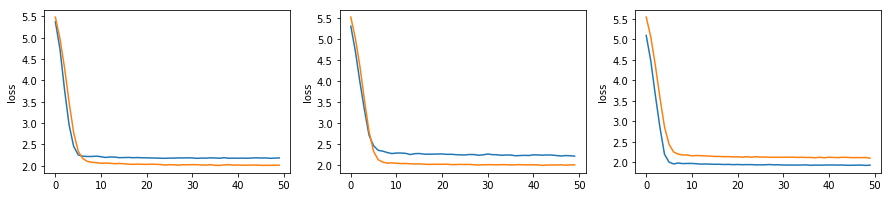

In [74]:
m_lineplot(df_his_list)

In [82]:
df_trial.to_pickle('../trial/kerasmlp.pkl')